In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
# Example 1

# Traffic management inspector in a certain city wants to understand whether carbon emissions from different cars are different. The inspector has reasons to believe that Fuel type (LPG, Petrol or Petrol (E85-Flex Fuel)) and car manufacturer (Audi, BMW, Ford, Volvo) may be the factors responsible for differences in carbon emission. For this purpose, she has taken random samples from all registered cars on the road in that city and would like to compare the amount of carbon emission release due to fuel type and/or manufacturers.
# This problem is essentially a problem of identification of the source(s) of variation in the data. ANOVA will be applied to see whether
#  Carbon emission depends on fuel type only (One-way ANOVA)
#  Carbon emission depends on manufacturer only (One-way ANOVA)
#  Carbon emission depends on both fuel type and manufacturer both (Two-way ANOVA)

# Solution: The objective is to determine whether CO2 emission from cards depend on manufacturer, fuel or both

aovdf = pd.read_csv('./AOVData.csv')

print(aovdf.shape)
print(aovdf.head())

# Factor 1: Fuel Type
# Factor 2: Manufacturer
# Response: CO_Emissions


(510, 4)
   Car_ID manufacturer fuel_type  co_emissions
0       1         Audi    Petrol        441.55
1       2          BMW       E85        376.47
2       3          BMW       E85        414.12
3       4          BMW       E85        351.41
4       5        Volvo       E85        284.59


In [14]:
aovdf['co_emissions'].describe().transpose()

count    510.000000
mean     358.456882
std       66.912999
min      162.070000
25%      312.630000
50%      356.190000
75%      410.645000
max      544.560000
Name: co_emissions, dtype: float64

(array([ 1.,  2.,  4., 12., 14., 26., 37., 57., 53., 64., 57., 39., 48.,
        39., 23., 16.,  9.,  3.,  5.]),
 array([160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400,
        420, 440, 460, 480, 500, 520, 540]),
 <BarContainer object of 19 artists>)

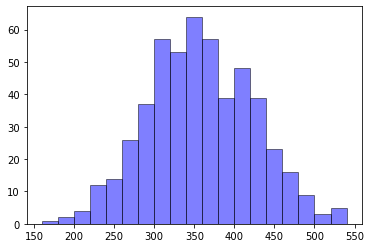

In [15]:
# Min value is 162 and max value is 544 and a step of 20 creates a normal distribution
bin_edges = np.arange(160, 560, 20)


# Visualize the pattern
plt.hist(aovdf.co_emissions, 
         bins=bin_edges, 
         density=False, 
         histtype='bar',
         color='b',
         edgecolor='k',
         alpha=0.5)


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


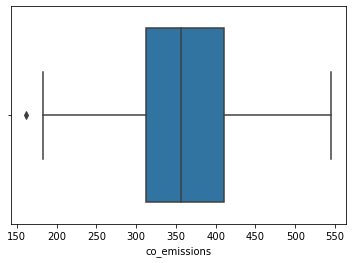

In [16]:
# Are there anu outliers?

sns.boxplot(aovdf['co_emissions'], orient='v')
plt.show()

In [20]:
# Frequency-counts and mean of carbon emission at 
# different levels of the factors

# Factor 1: fuel_type

# Frequency count
print(aovdf['fuel_type'].value_counts())

# Mean
print(aovdf.groupby('fuel_type')['co_emissions'].mean())


Petrol    179
LPG       170
E85       161
Name: fuel_type, dtype: int64
fuel_type
E85       338.124534
LPG       363.744412
Petrol    371.722961
Name: co_emissions, dtype: float64


In [21]:
# Factor 2: Manufacturer

# Frequency
print(aovdf['manufacturer'].value_counts())

# Mean
print(aovdf.groupby('manufacturer')['co_emissions'].mean())

Audi     142
Ford     132
Volvo    123
BMW      113
Name: manufacturer, dtype: int64
manufacturer
Audi     349.727254
BMW      377.538761
Ford     365.078561
Volvo    343.898293
Name: co_emissions, dtype: float64


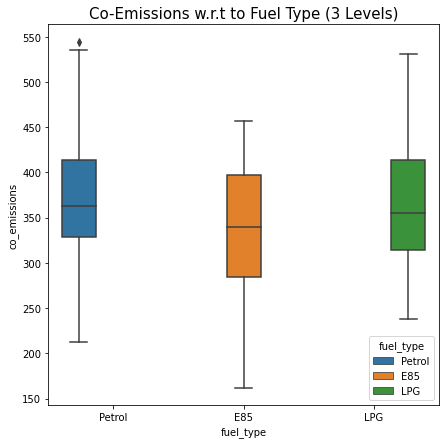

In [22]:
# Problem 1: Whether there is any dependency on 𝑌 of 𝑋1: Fuel Type
# Whether there is any dependency on Co-Emissions of Fuel_Type

# We need to test the hypothesis that the use of 
# three different fuel types does not impact carbon emission.

# H0: Mean for Carbon Emissions of all fuel_type are the same.
# H1: Mean for Carbon Emissions of atleast one fuel_type is different from the other.

# The normality and equality of variance assumptions need to be checked.


a4_dims = (7,7)
fig, ax = plt.subplots(figsize=a4_dims)
a = sns.boxplot(x='fuel_type', y='co_emissions', data=aovdf, hue='fuel_type')
a.set_title('Co-Emissions w.r.t to Fuel Type (3 Levels)', fontsize=15)
plt.show()


In [23]:
# For testing of normality, Shapiro-Wilk’s test is applied to the response

# H0: Co-Emission follow a normal distribution
# Ha: Co-Emission doesn't follow a normal distribution.

# Assumption 1: Is the Dependant Variable normally distributed?

from scipy import stats

w, p_value = stats.shapiro(aovdf['co_emissions'])

print("W={} and p_value={}".format(w, p_value))

# p_value is not less than alpha i.e. 0.05, hence we fail to reject H0 and 
# The reponse vairable "co-emissions" follow a normal distribution

W=0.9970714449882507 and p_value=0.49723097681999207


In [24]:
# Assumption 2: Variance of co_emissions is equal at all levels of fuel_type

# we need to test the assumption that 
# at all three levels of the factor fuel_type, population variance is equal

# H0: variance1 = variance2 = variance3 
# Ha: Atleast one variabce is different from the rest.

co_emissions_col = aovdf['co_emissions']
fuel_type_col = aovdf['fuel_type']

statistic, p_value = stats.levene(co_emissions_col[fuel_type_col == 'Petrol'], 
             co_emissions_col[fuel_type_col == 'E85'], 
             co_emissions_col[fuel_type_col == 'LPG'])

print('Statistic is {}  and P_value is {}'.format(statistic, p_value))

# P value is not less than alpha 0.05, hence we fail to reject H0:
# Variances of the co-emissions of fuel_type are the same.

Statistic is 1.6432552897712633  and P_value is 0.19437768490117


In [27]:
# Once the two assumptions of one-way ANOVA are satisfied, 
# we can now compare the population means.

# Apply one-way ANOVA
# H0: meanFuel1 = meanFuel2 = meanFuel3
# Ha: Atleast one mean is different

from statsmodels.formula.api import ols # for n-way- anova
from statsmodels.stats.anova import _get_covariance, anova_lm

formula = 'co_emissions ~ C(fuel_type)'

model = ols(formula, data=aovdf).fit()
aov_tbl = anova_lm(model, type=1)
print(aov_tbl)

# Obtained P Value 0.000008 is less than Alpha 0.05 hence the Null Hypothesis
# H0: Mean(s) for the fuel types are identical is Rejected.


                 df        sum_sq       mean_sq          F    PR(>F)
C(fuel_type)    2.0  1.028130e+05  51406.481215  11.976652  0.000008
Residual      507.0  2.176158e+06   4292.224647        NaN       NaN


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Residuals')

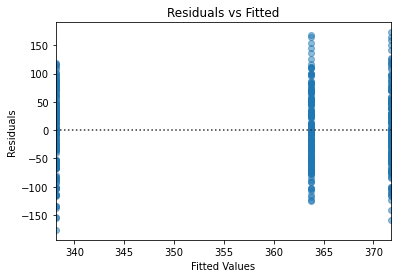

In [28]:
# Residuals are defined as the difference between the observed values 
# and the expected values. 
# Detail discussion on residuals will be taken up along with Simple Linear Regression. 
# The following two graphs are introduced to check the distribution of the residuals. 
# Fig 10 indicates that the mean carbon emission of two groups are close but the other group means stands out. 
# It also supports the homoscedasticity of variances.
# Fig 11 indicates that the normality assumption holds.


# model values
model_fitted_y = model.fittedvalues

# model residuals
model_residuals = model.resid

# normalized residuals
model_norm_residuals = model.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = model.get_influence().hat_matrix_diag

# cooks dist ance, from statsmodels internals
model_cooks = model.get_influence().cooks_distance[0]

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, 'co_emissions', data=aovdf, lowess=True, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted Values')
plot_lm_1.axes[0].set_ylabel('Residuals')



In [29]:
# QQ = ProbPlot(model_norm_residuals) 
# plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1) 
# plot_lm_2.axes[0].set_title('Normal Q-Q')

# plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles') 
# plot_lm_2.axes[0].set_ylabel('Standardized Residuals'); 
# # annotations 
# abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0) 
# abs_norm_resid_top_3 = abs_norm_resid[:3] 
# for r, i in enumerate(abs_norm_resid_top_3): plot_lm_2.axes[0].annotate(i,xy=(np.flip(QQ.theoretical_quantiles, 0)[r],model_norm_residuals[i]))

NameError: name 'ProbPlot' is not defined

In [30]:
# Problem 1: Whether there is any dependency on 𝑌 of 𝑋2: Maufacturer
# Whether there is any dependency on Co-Emissions of Maufacturer

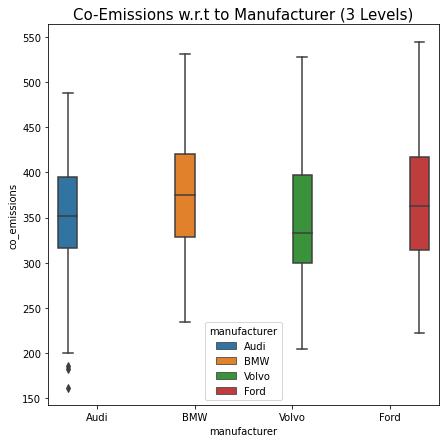

In [32]:
# visual comparo of group means

a4_dims = (7,7)
fig, ax = plt.subplots(figsize=a4_dims)
a = sns.boxplot(x='manufacturer', y='co_emissions', data=aovdf, hue='manufacturer')
a.set_title('Co-Emissions w.r.t to Manufacturer (3 Levels)', fontsize=15)
plt.show()

In [34]:
# Assumption 1: Is the Dependant Variable normally distributed is already tested
# And it is normally distributed

# Assumption 2: Variance of co_emissions is equal at all levels of manufacturer

# we need to test the assumption that 
# at all four levels of the factor manufacturer, population variance is equal

# H0: variance1 = variance2 = variance3 
# Ha: Atleast one variabce is different from the rest.

co_emissions_col = aovdf['co_emissions']
manufacturer_col = aovdf['manufacturer']

statistic, p_value = stats.levene(co_emissions_col[manufacturer_col == 'Audi'], 
             co_emissions_col[manufacturer_col == 'BMW'], 
             co_emissions_col[manufacturer_col == 'Volvo'],
             co_emissions_col[manufacturer_col == 'Ford'])

print('Statistic is {}  and P_value is {}'.format(statistic, p_value))

# P value is not less than alpha 0.05, hence we fail to reject H0:
# Variances of co-emissions of all levels of manufacturer are the same.

Statistic is 1.5475641565613962  and P_value is 0.20131599109069698


In [35]:
# One-way ANOVA for factor Manufacturer

formula = 'co_emissions ~ C(manufacturer)'

model = ols(formula, data=aovdf).fit()
aov_tbl = anova_lm(model, type=1)
print(aov_tbl)

# As the P Value is less than Alpha 0.05 we reject the null hypothesis 
# H0 Means for co-emissions for various manufacturers is Rejected.


                    df        sum_sq       mean_sq        F    PR(>F)
C(manufacturer)    3.0  8.382457e+04  27941.524040  6.44076  0.000276
Residual         506.0  2.195146e+06   4338.233767      NaN       NaN


manufacturer  Audi  BMW  Ford  Volvo
fuel_type                           
E85             47   34    41     39
LPG             47   35    46     42
Petrol          48   44    45     42
fuel_type  manufacturer
E85        Audi            330.330638
           BMW             339.697353
           Ford            337.320488
           Volvo           346.991282
LPG        Audi            356.111702
           BMW             382.215429
           Ford            379.806739
           Volvo           339.301190
Petrol     Audi            362.468333
           BMW             403.059773
           Ford            375.313778
           Volvo           345.623333
Name: co_emissions, dtype: float64


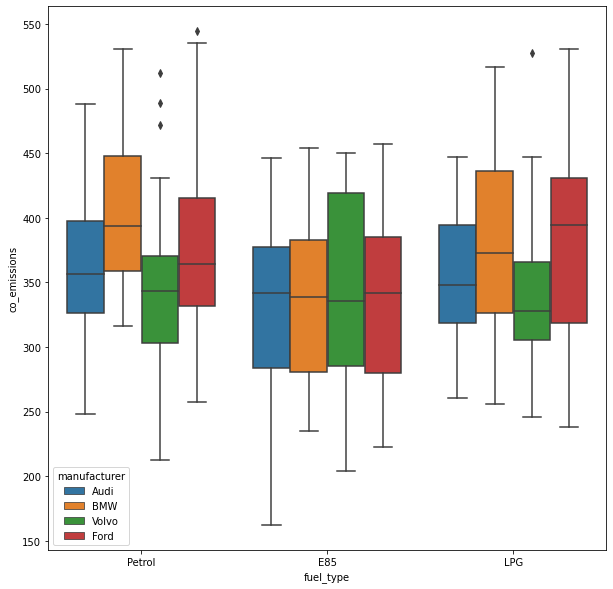

In [41]:
# Two-Way ANOVA

# Problem 3: whether there is any dependency on 𝑌 of 𝑋1 𝑎𝑛𝑑 𝑋2 (Fuel type and Manufacturer) together

# Before two-way ANOVA procedure is applied to the data, descriptive analysis is done.

print(pd.crosstab(aovdf['fuel_type'], aovdf['manufacturer']))

print(aovdf.groupby(['fuel_type', 'manufacturer'])['co_emissions'].mean())

fig, axes = plt.subplots()
fig.set_size_inches(10, 10)
a = sns.boxplot(data=aovdf, y='co_emissions', x='fuel_type', hue='manufacturer', orient='v')

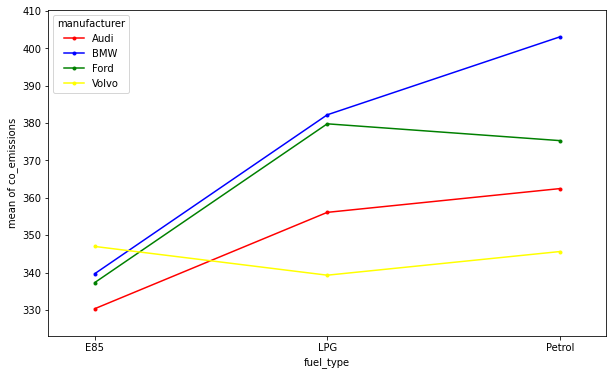

In [46]:
from statsmodels.graphics.factorplots import interaction_plot
fig, ax = plt.subplots(figsize=(10, 6)) 
fig = interaction_plot(x=aovdf['fuel_type'], trace=aovdf['manufacturer'], response=aovdf["co_emissions"],colors=['red', 'blue','green','yellow'], ylabel='co_emissions', xlabel='fuel_type',ax=ax) 
plt.show()

In [48]:
# Assumption1 is already tested
# Assumnption2 varaince equality needs to be tested

statistic, p_value = stats.levene(aovdf['co_emissions'][aovdf['fuel_type']=="Petrol"][aovdf['manufacturer']=="Audi"], 
                                  aovdf['co_emissions'][aovdf['fuel_type']=="E85"][aovdf['manufacturer']=="Audi"],
                                  aovdf['co_emissions'][aovdf['fuel_type']=="LPG"][aovdf['manufacturer']=="Audi"],
                                  aovdf['co_emissions'][aovdf['fuel_type']=="Petrol"][aovdf['manufacturer']=="BMW"],
                                  aovdf['co_emissions'][aovdf['fuel_type']=="E85"][aovdf['manufacturer']=="BMW"],
                                  aovdf['co_emissions'][aovdf['fuel_type']=="LPG"][aovdf['manufacturer']=="BMW"], 
                                  aovdf['co_emissions'][aovdf['fuel_type']=="Petrol"][aovdf['manufacturer']=="Ford"],
                                  aovdf['co_emissions'][aovdf['fuel_type']=="E85"][aovdf['manufacturer']=="Ford"],
                                  aovdf['co_emissions'][aovdf['fuel_type']=="LPG"][aovdf['manufacturer']=="Ford"],
                                  aovdf['co_emissions'][aovdf['fuel_type']=="Petrol"][aovdf['manufacturer']=="Volvo"],
                                  aovdf['co_emissions'][aovdf['fuel_type']=="E85"][aovdf['manufacturer']=="Volvo"],
                                  aovdf['co_emissions'][aovdf['fuel_type']=="LPG"][aovdf['manufacturer']=="Volvo"]) 
print("statistic = {}".format(w), "p_value = {}".format(p_value))

# P value is greater than alpha 0.05, hence the H0 Variances are equal is not rejected.

statistic = 0.9970714449882507 p_value = 0.06799587238101185


In [51]:
# Two-Way ANOVA
formula = 'co_emissions ~ C(fuel_type) + C(manufacturer) + C(fuel_type):C(manufacturer)'
model = ols(formula, data=aovdf).fit()
aov_tbl = anova_lm(model, type=2)
print(aov_tbl)

# P value is less than alpha 0.05 hence the null hypothesis that equality of means for manufacturer and fuel level is also rejected

                                 df        sum_sq       mean_sq          F  \
C(fuel_type)                    2.0  1.028130e+05  51406.481215  12.537086   
C(manufacturer)                 3.0  7.933563e+04  26445.211438   6.449496   
C(fuel_type):C(manufacturer)    6.0  5.484639e+04   9141.064215   2.229336   
Residual                      498.0  2.041976e+06   4100.353165        NaN   

                                PR(>F)  
C(fuel_type)                  0.000005  
C(manufacturer)               0.000273  
C(fuel_type):C(manufacturer)  0.039199  
Residual                           NaN  
